In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.stats import t

# Read data from Excel file
file_path = "/Users/szonyid/Desktop/TDK_2024/Data/UK_Yields.xlsx"
#file_path = "/content/US_Yields.xls"
df = pd.read_excel(file_path)
df.dropna(inplace=True)
df['US_bp_change'] = df['UK_yield'].diff() * 100
df.dropna(inplace=True)

# Define event dates for different categories of Fed announcements
fed_announcement_dates = {
    "QE1": ["2009-03-05", "2009-05-07", "2009-08-06", "2009-11-05"],  
    "QE2": ["2011-10-06", "2012-02-09"],  
    "QE3": ["2012-07-05"],  
    "QE4": ["2016-08-04"],  
    "QE5": ["2020-03-19", "2020-06-18", "2020-11-05"],
    "QT": ["2021-08-05", "2022-02-03", "2022-05-05", "2022-08-04", "2022-09-22"]
}

# Define event dates for ECB and BoE announcements
ecb_announcement_dates = ["2010-05-10", "2011-08-07", "2012-07-26", "2012-08-02", "2012-09-06", "2015-01-22", "2015-12-03", "2016-03-10", "2016-12-08",
                          "2019-09-12", "2020-03-12", "2020-03-18", "2020-06-04", "2020-12-10", "2021-12-16", "2022-06-09", "2022-12-15", "2023-05-04", "2023-12-14"]

boe_announcement_dates = ["2008-11-25", "2008-12-01", "2008-12-16", "2009-01-28", "2009-03-18", "2010-08-10", "2010-08-27", "2010-09-21", "2010-11-03", "2011-09-21", "2012-06-20",
                          "2012-09-13", "2012-12-12", "2013-05-22", "2013-06-19", "2014-05-21", "2014-07-09", "2014-08-20", "2014-09-17", "2017-04-05", "2017-05-24", "2017-06-14", "2017-09-20",
                          "2020-03-16", "2020-03-23", "2020-06-10", "2022-01-05", "2022-01-26", "2022-05-04"]

# Create binary dummy variables for ECB and BoE announcements
df['ECB_dummy'] = np.where(df['Date'].isin(ecb_announcement_dates), 1, 0)
df['BoE_dummy'] = np.where(df['Date'].isin(boe_announcement_dates), 1, 0)

# Define window sizes
estimation_window_size = 240
cool_off_period_size = 10

# Initialize dictionaries to store results for each event type
results = {}

In [2]:
# Iterate over each category and its associated event dates
for category, event_dates in fed_announcement_dates.items():
    print(f"Analyzing category: {category}")

    results[category] = []

    for event_date in event_dates:
        print(f"Event date: {event_date}")

        # Create binary dummy variables for the Fed announcements
        df[f'{category}_dummy'] = np.where(df['Date'] == pd.to_datetime(event_date), 1, 0)

        # Define event window for the specific category
        event_window = df[df['Date'] == pd.to_datetime(event_date)]

        # Filter the DataFrame for the cool-off period and estimation window
        cool_off_period_end_index = df[df['Date'] == pd.to_datetime(event_date)].index[0] - 1
        cool_off_period_start_index = cool_off_period_end_index - cool_off_period_size
        cool_off_period = df.loc[cool_off_period_start_index:cool_off_period_end_index]

        estimation_window_end_index = cool_off_period_start_index - 1
        estimation_window_start_index = estimation_window_end_index - estimation_window_size
        estimation_window = df.loc[estimation_window_start_index:estimation_window_end_index]

        # Linear regression for the specific category
        X = sm.add_constant(estimation_window[['ECB_dummy', 'BoE_dummy']])
        y = estimation_window['US_bp_change']
        model = sm.OLS(y, X).fit()

        # Calculate expected return for the event day
        expected_return_event = (
            model.params['const'] +
            model.params['ECB_dummy'] * event_window['ECB_dummy'].iloc[0] +
            model.params['BoE_dummy'] * event_window['BoE_dummy'].iloc[0]
        )

        ### AR(0) ###
        # Calculate actual return for the event day
        actual_return_event = event_window['US_bp_change'].iloc[0]

        # Calculate abnormal return for the event day
        abnormal_return = actual_return_event - expected_return_event

        # Calculate t-statistic and p-value
        t_statistic = abnormal_return / estimation_window["US_bp_change"].std()
        degrees_of_freedom = len(estimation_window) - len(model.params)
        p_value = 2 * (1 - t.cdf(abs(t_statistic), df=degrees_of_freedom))

        ### AR(1) ###
        # Calculate expected return for the day after the event
        event_date_plus_1 = pd.to_datetime(event_date) + pd.Timedelta(days=1)
        event_window_plus_1 = df[df['Date'] == event_date_plus_1]

        if event_window_plus_1.empty:
            # If data is not available, find the closest next trading day
            next_trading_day = df[df['Date'] > pd.to_datetime(event_date)].iloc[0]
            # Use the data from the closest next trading day
            actual_return_event_plus_1 = next_trading_day['US_bp_change']
        else:
            # Use the data for the day after the event
            actual_return_event_plus_1 = event_window_plus_1['US_bp_change'].iloc[0]

        # Calculate abnormal return for the day after the event
        abnormal_return_plus_1 = actual_return_event_plus_1 - expected_return_event

        # Calculate t-statistic and p-value for the day after the event
        t_statistic_plus_1 = abnormal_return_plus_1 / estimation_window["US_bp_change"].std()
        p_value_plus_1 = 2 * (1 - t.cdf(abs(t_statistic_plus_1), df=degrees_of_freedom))

        ### AR(-1) ###
        # Calculate expected return for the day before the event
        event_date_minus_1 = pd.to_datetime(event_date) - pd.Timedelta(days=1)
        event_window_minus_1 = df[df['Date'] == event_date_minus_1]

        # Check if data for the previous day is available
        if event_window_minus_1.empty:
            # If data is not available, find the closest previous trading day
            previous_trading_day = df[df['Date'] < pd.to_datetime(event_date)].iloc[-1]
            # Use the data from the closest previous trading day
            actual_return_event_minus_1 = previous_trading_day['US_bp_change']
        else:
            # Use the data for the day before the event
            actual_return_event_minus_1 = event_window_minus_1['US_bp_change'].iloc[0]

        # Calculate abnormal return for the day before the event
        abnormal_return_minus_1 = actual_return_event_minus_1 - expected_return_event

        # Calculate t-statistic and p-value for the day before the event
        t_statistic_minus_1 = abnormal_return_minus_1 / estimation_window["US_bp_change"].std()
        p_value_minus_1 = 2 * (1 - t.cdf(abs(t_statistic_minus_1), df=degrees_of_freedom))
        
        # Calculate cumulative abnormal return i.e. CAR(0,1)
        cumulative_abnormal_return = abnormal_return + abnormal_return_plus_1

        # Calculate t-statistic and p-value for CAR(0,1)
        cumulative_abnormal_return_t_statistic = cumulative_abnormal_return / estimation_window["US_bp_change"].std()
        cumulative_abnormal_return_p_value = 2 * (1 - t.cdf(abs(cumulative_abnormal_return_t_statistic), df=degrees_of_freedom))

        # Append results to the list
        results[category].append({
            "Event_Date": event_date,
            "Abnormal_Return": abnormal_return,
            "t_statistic": t_statistic,
            "p_value": p_value,
            "Abnormal_Return_Plus_1": abnormal_return_plus_1,
            "t_statistic_plus_1": t_statistic_plus_1,
            "p_value_plus_1": p_value_plus_1,
            "Abnormal_Return_Minus_1": abnormal_return_minus_1,
            "t_statistic_minus_1": t_statistic_minus_1,
            "p_value_minus_1": p_value_minus_1,
            "Cumulative_Abnormal_Return": cumulative_abnormal_return,
            "CAR_t_statistic": cumulative_abnormal_return_t_statistic,
            "CAR_p_value": cumulative_abnormal_return_p_value
        })

Analyzing category: QE1
Event date: 2009-03-05
Event date: 2009-05-07
Event date: 2009-08-06
Event date: 2009-11-05
Analyzing category: QE2
Event date: 2011-10-06
Event date: 2012-02-09
Analyzing category: QE3
Event date: 2012-07-05
Analyzing category: QE4
Event date: 2016-08-04
Analyzing category: QE5
Event date: 2020-03-19
Event date: 2020-06-18
Event date: 2020-11-05
Analyzing category: QT
Event date: 2021-08-05
Event date: 2022-02-03
Event date: 2022-05-05
Event date: 2022-08-04
Event date: 2022-09-22


In [3]:
results['QE1'][0]

{'Event_Date': '2009-03-05',
 'Abnormal_Return': -31.43836912811721,
 't_statistic': -4.6838558579009515,
 'p_value': 4.815864240725887e-06,
 'Abnormal_Return_Plus_1': -36.29124339005928,
 't_statistic_plus_1': -5.406862940323848,
 'p_value_plus_1': 1.6030266847266716e-07,
 'Abnormal_Return_Minus_1': 8.46317369795747,
 't_statistic_minus_1': 1.26088874203588,
 'p_value_minus_1': 0.2086264559538593,
 'Cumulative_Abnormal_Return': -67.72961251817648,
 'CAR_t_statistic': -10.090718798224799,
 'CAR_p_value': 0.0}

In [4]:
# Initialize dictionary to store aggregated abnormal returns for each announcement category
aggregated_abnormal_returns = {}

# Initialize dictionary to store AAR for each announcement category
aar = {}

# Iterate over each announcement category and its associated event dates
for category, event_dates in fed_announcement_dates.items():
    # Initialize aggregated abnormal returns for the current category
    aggregated_abnormal_returns[category] = {'Abnormal_Return': 0, 'Abnormal_Return_Plus_1': 0}
    
    # Iterate over each event date in the current category
    for event_date in event_dates:
        # Retrieve abnormal returns for the current event
        event_abnormal_returns = [result['Abnormal_Return'] for result in results[category] if result['Event_Date'] == event_date]
        event_abnormal_returns_plus_1 = [result['Abnormal_Return_Plus_1'] for result in results[category] if result['Event_Date'] == event_date]
        
        # Aggregate abnormal returns for the current event
        aggregated_abnormal_returns[category]['Abnormal_Return'] += event_abnormal_returns[0] if event_abnormal_returns else 0
        aggregated_abnormal_returns[category]['Abnormal_Return_Plus_1'] += event_abnormal_returns_plus_1[0] if event_abnormal_returns_plus_1 else 0

# Calculate AAR for each announcement category
for category, abnormal_returns in aggregated_abnormal_returns.items():
    num_events = len(fed_announcement_dates[category])  # Number of events for the current category
    aar[category] = {key: value / num_events for key, value in abnormal_returns.items()}

# Display AAR for each announcement category
print("Averaged Abnormal Returns (AAR) for Each Announcement Category:")
for category, values in aar.items():
    print(f"{category}: {values}")

Averaged Abnormal Returns (AAR) for Each Announcement Category:
QE1: {'Abnormal_Return': -6.298060483404206, 'Abnormal_Return_Plus_1': -5.91930596559504}
QE2: {'Abnormal_Return': 5.441251635530312, 'Abnormal_Return_Plus_1': -0.8030152866714797}
QE3: {'Abnormal_Return': -5.374306755539665, 'Abnormal_Return_Plus_1': -5.743191648000584}
QE4: {'Abnormal_Return': -16.230257265222797, 'Abnormal_Return_Plus_1': 2.5671941006715735}
QE5: {'Abnormal_Return': 3.5873454596410803, 'Abnormal_Return_Plus_1': -8.033031312827994}
QT: {'Abnormal_Return': 4.253473565342964, 'Abnormal_Return_Plus_1': 12.194133327706286}


In [5]:
# Initialize dictionaries to store t-statistics and p-values for AAR(0) and AAR(1) for each individual announcement category
t_statistics_individual = {}
p_values_individual = {}

# Iterate over each announcement category and calculate t-statistics and p-values for both AAR(0) and AAR(1)
for category, results_list in results.items():
    num_events = len(fed_announcement_dates[category])  # Number of events for the current category
    
    # Extract abnormal returns for AAR(0) and AAR(1) from the results list
    aar_0_values = [result['Abnormal_Return'] for result in results_list]
    aar_plus_1_values = [result['Abnormal_Return_Plus_1'] for result in results_list]
    
    # Calculate average abnormal return at the event date (AAR(0))
    aar_0 = np.mean(aar_0_values)
    
    # Calculate standard deviation of abnormal returns at the event date (AAR(0))
    std_dev_ar_0 = np.std(aar_0_values, ddof=1)
    
    # Calculate t-statistic for AAR(0)
    t_statistic_aar_0 = (aar_0 / std_dev_ar_0) * np.sqrt(num_events)
    
    # Calculate p-value for AAR(0)
    p_value_aar_0 = 2 * (1 - t.cdf(abs(t_statistic_aar_0), df=num_events - 1))
    
    # Calculate average abnormal return at the event date (plus 1) (AAR(1))
    aar_plus_1 = np.mean(aar_plus_1_values)
    
    # Calculate standard deviation of abnormal returns at the event date (plus 1) (AAR(1))
    std_dev_ar_plus_1 = np.std(aar_plus_1_values, ddof=1)
    
    # Calculate t-statistic for AAR(1)
    t_statistic_aar_plus_1 = (aar_plus_1 / std_dev_ar_plus_1) * np.sqrt(num_events)
    
    # Calculate p-value for AAR(1)
    p_value_aar_plus_1 = 2 * (1 - t.cdf(abs(t_statistic_aar_plus_1), df=num_events - 1))
    
    # Store t-statistics and p-values for both AAR(0) and AAR(1)
    t_statistics_individual[category] = {'AAR(0)': t_statistic_aar_0, 'AAR(1)': t_statistic_aar_plus_1}
    p_values_individual[category] = {'AAR(0)': p_value_aar_0, 'AAR(1)': p_value_aar_plus_1}

# Display t-statistics and p-values for both AAR(0) and AAR(1) for each individual announcement category
print("\nT-Statistics and p-values for AAR(0) and AAR(1) for Each Individual Announcement Category:")
for category, stats in t_statistics_individual.items():
    print(f"{category}:")
    print(f"   AAR(0) t-statistic: {stats['AAR(0)']}, p-value: {p_values_individual[category]['AAR(0)']}")
    print(f"   AAR(1) t-statistic: {stats['AAR(1)']}, p-value: {p_values_individual[category]['AAR(1)']}")


T-Statistics and p-values for AAR(0) and AAR(1) for Each Individual Announcement Category:
QE1:
   AAR(0) t-statistic: -0.7008151194336727, p-value: 0.533884389187248
   AAR(1) t-statistic: -0.5844338401917287, p-value: 0.5999738625287012
QE2:
   AAR(0) t-statistic: 7.939364752468085, p-value: 0.07976518413709299
   AAR(1) t-statistic: -0.09026929082043098, p-value: 0.9426881172835968
QE3:
   AAR(0) t-statistic: nan, p-value: nan
   AAR(1) t-statistic: nan, p-value: nan
QE4:
   AAR(0) t-statistic: nan, p-value: nan
   AAR(1) t-statistic: nan, p-value: nan
QE5:
   AAR(0) t-statistic: 5.147218792140277, p-value: 0.03573372824946164
   AAR(1) t-statistic: -0.7217358988896759, p-value: 0.5454305289217336
QT:
   AAR(0) t-statistic: 0.9661467671370149, p-value: 0.38868208949611516
   AAR(1) t-statistic: 2.6795708632329385, p-value: 0.05525322149660439


/Users/szonyid/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/szonyid/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [6]:
# Create aggregated categories
aggregated_categories = {
    "Akkomodációs QE": ["QE1", "QE2", "QE3", "QE4"],
    "Kettős célú QE": ["QE5"],
    "QE": ["QE1", "QE2", "QE3", "QE4", "QE5"],
    "QT": ["QT"],
}

# Initialize dictionary to store aggregated abnormal returns for each aggregated announcement category
aggregated_abnormal_returns = {}

# Initialize dictionary to store AAR for each aggregated announcement category
aar_aggregated = {}

# Iterate over each aggregated announcement category
for aggregated_category, subcategories in aggregated_categories.items():
    # Initialize aggregated abnormal returns for the current aggregated category
    aggregated_abnormal_returns[aggregated_category] = {'Abnormal_Return': 0, 'Abnormal_Return_Plus_1': 0}
    
    # Iterate over each subcategory and aggregate abnormal returns
    for subcategory in subcategories:
        # Aggregate abnormal returns for the current subcategory
        aggregated_abnormal_returns[aggregated_category]['Abnormal_Return'] += aar[subcategory]['Abnormal_Return']
        aggregated_abnormal_returns[aggregated_category]['Abnormal_Return_Plus_1'] += aar[subcategory]['Abnormal_Return_Plus_1']
    
    # Calculate the average AAR for the aggregated category
    num_subcategories = len(subcategories)
    aar_aggregated[aggregated_category] = {
        'Abnormal_Return': aggregated_abnormal_returns[aggregated_category]['Abnormal_Return'] / num_subcategories,
        'Abnormal_Return_Plus_1': aggregated_abnormal_returns[aggregated_category]['Abnormal_Return_Plus_1'] / num_subcategories
    }

# Display AAR for each aggregated announcement category
print("Averaged Abnormal Returns (AAR) for Each Aggregated Announcement Category:")
for category, values in aar_aggregated.items():
    print(f"{category}: {values}")

Averaged Abnormal Returns (AAR) for Each Aggregated Announcement Category:
Akkomodációs QE: {'Abnormal_Return': -5.615343217159089, 'Abnormal_Return_Plus_1': -2.4745796998988827}
Kettős célú QE: {'Abnormal_Return': 3.5873454596410803, 'Abnormal_Return_Plus_1': -8.033031312827994}
QE: {'Abnormal_Return': -3.774805481799055, 'Abnormal_Return_Plus_1': -3.5862700224847046}
QT: {'Abnormal_Return': 4.253473565342964, 'Abnormal_Return_Plus_1': 12.194133327706286}


In [7]:
# Create aggregated event dates dictionary
aggregated_event_dates = {
    "Akkomodációs QE": fed_announcement_dates["QE1"] + fed_announcement_dates["QE2"] + fed_announcement_dates["QE3"] + fed_announcement_dates["QE4"],
    "Kettős célú QE": fed_announcement_dates["QE5"],
    "QE": fed_announcement_dates["QE1"] + fed_announcement_dates["QE2"] + fed_announcement_dates["QE3"] + fed_announcement_dates["QE4"] + fed_announcement_dates["QE5"],
    "QT": fed_announcement_dates["QT"]
}

# Initialize dictionaries to store aggregated abnormal returns for each aggregated announcement category
aggregated_results = {}

# Aggregate results for each aggregated announcement category
for category, subcategories in aggregated_categories.items():
    aggregated_results[category] = []
    for subcategory in subcategories:
        aggregated_results[category].extend(results[subcategory])

# Initialize dictionaries to store t-statistics and p-values for AAR(0) and AAR(1) for each aggregated announcement category
t_statistics = {}
p_values = {}

# Iterate over each aggregated announcement category and calculate t-statistics and p-values for both AAR(0) and AAR(1)
for category, results_list in aggregated_results.items():
    num_events = len(aggregated_event_dates[category])  # Number of events for the current category
    
    # Extract abnormal returns for AAR(0) and AAR(1) from the aggregated results list
    aar_0_values = [result['Abnormal_Return'] for result in results_list]
    aar_plus_1_values = [result['Abnormal_Return_Plus_1'] for result in results_list]
    
    # Calculate average abnormal return at the event date (AAR(0))
    aar_0 = np.mean(aar_0_values)
    
    # Calculate standard deviation of abnormal returns at the event date (AAR(0))
    std_dev_ar_0 = np.std(aar_0_values, ddof=1)
    
    # Calculate t-statistic for AAR(0)
    t_statistic_aar_0 = (aar_0 / std_dev_ar_0) * np.sqrt(num_events)
    
    # Calculate p-value for AAR(0)
    p_value_aar_0 = 2 * (1 - t.cdf(abs(t_statistic_aar_0), df=num_events - 1))
    
    # Calculate average abnormal return at the event date (plus 1) (AAR(1))
    aar_plus_1 = np.mean(aar_plus_1_values)
    
    # Calculate standard deviation of abnormal returns at the event date (plus 1) (AAR(1))
    std_dev_ar_plus_1 = np.std(aar_plus_1_values, ddof=1)
    
    # Calculate t-statistic for AAR(1)
    t_statistic_aar_plus_1 = (aar_plus_1 / std_dev_ar_plus_1) * np.sqrt(num_events)
    
    # Calculate p-value for AAR(1)
    p_value_aar_plus_1 = 2 * (1 - t.cdf(abs(t_statistic_aar_plus_1), df=num_events - 1))
    
    # Store t-statistics and p-values for both AAR(0) and AAR(1)
    t_statistics[category] = {'AAR(0)': t_statistic_aar_0, 'AAR(1)': t_statistic_aar_plus_1}
    p_values[category] = {'AAR(0)': p_value_aar_0, 'AAR(1)': p_value_aar_plus_1}

# Display t-statistics and p-values for both AAR(0) and AAR(1) for each aggregated announcement category
print("\nT-Statistics and p-values for AAR(0) and AAR(1) for Each Aggregated Announcement Category:")
for category, stats in t_statistics.items():
    print(f"{category}:")
    print(f"   AAR(0) t-statistic: {stats['AAR(0)']}, p-value: {p_values[category]['AAR(0)']}")
    print(f"   AAR(1) t-statistic: {stats['AAR(1)']}, p-value: {p_values[category]['AAR(1)']}")


T-Statistics and p-values for AAR(0) and AAR(1) for Each Aggregated Announcement Category:
Akkomodációs QE:
   AAR(0) t-statistic: -0.9250036493073845, p-value: 0.385742331490718
   AAR(1) t-statistic: -0.6945641335144095, p-value: 0.5097171514809118
Kettős célú QE:
   AAR(0) t-statistic: 5.147218792140277, p-value: 0.03573372824946164
   AAR(1) t-statistic: -0.7217358988896759, p-value: 0.5454305289217336
QE:
   AAR(0) t-statistic: -0.6267145267478048, p-value: 0.5448872720377429
   AAR(1) t-statistic: -1.0550531510725407, p-value: 0.3162243545494594
QT:
   AAR(0) t-statistic: 0.9661467671370149, p-value: 0.38868208949611516
   AAR(1) t-statistic: 2.6795708632329385, p-value: 0.05525322149660439


In [8]:
# Initialize dictionaries to store CAAR for each announcement category
caar_individual = {}
caar_aggregated = {}

# Calculate CAAR for each individual announcement category
for category, values in aar.items():
    # Calculate CAAR for the current category
    caar_individual[category] = values['Abnormal_Return'] + values['Abnormal_Return_Plus_1']

# Display CAAR for each individual announcement category
print("\nCumulative Average Abnormal Returns (CAAR) for Each Announcement Category:")
for category, value in caar_individual.items():
    print(f"{category}: {value}")

# Calculate CAAR for each aggregated announcement category
for category, values in aar_aggregated.items():
    # Calculate CAAR for the current aggregated category
    caar_aggregated[category] = values['Abnormal_Return'] + values['Abnormal_Return_Plus_1']

# Display CAAR for each aggregated announcement category
print("\nCumulative Average Abnormal Returns (CAAR) for Each Aggregated Announcement Category:")
for category, value in caar_aggregated.items():
    print(f"{category}: {value}")


Cumulative Average Abnormal Returns (CAAR) for Each Announcement Category:
QE1: -12.217366448999247
QE2: 4.6382363488588325
QE3: -11.11749840354025
QE4: -13.663063164551223
QE5: -4.445685853186914
QT: 16.44760689304925

Cumulative Average Abnormal Returns (CAAR) for Each Aggregated Announcement Category:
Akkomodációs QE: -8.089922917057972
Kettős célú QE: -4.445685853186914
QE: -7.361075504283759
QT: 16.44760689304925


In [9]:
# Initialize dictionaries to store CAAR and t-statistics for CAAR for each aggregated announcement category
caar_aggregated = {}
t_statistics_caar = {}
p_values_caar = {}
alpha = 0.05

# Iterate over each aggregated announcement category and calculate CAAR
for category, values in aar_aggregated.items():
    # Calculate CAAR for the current aggregated category
    caar_aggregated[category] = values['Abnormal_Return'] + values['Abnormal_Return_Plus_1']

    # Calculate standard deviation of AAR(0) for the current aggregated category
    aar_0_values = [result['Abnormal_Return'] for subcategory in aggregated_categories[category] for result in results[subcategory]]
    aar_0_mean = np.mean(aar_0_values)
    aar_0_variance = np.sum([(aar - aar_0_mean) ** 2 for aar in aar_0_values]) / (len(aar_0_values) - 1)
    std_dev_aar_0 = np.sqrt(aar_0_variance)
    
    # Calculate standard deviation of AAR(1) for the current aggregated category
    aar_1_values = [result['Abnormal_Return_Plus_1'] for subcategory in aggregated_categories[category] for result in results[subcategory]]
    aar_1_mean = np.mean(aar_1_values)
    aar_1_variance = np.sum([(aar - aar_1_mean) ** 2 for aar in aar_1_values]) / (len(aar_1_values) - 1)
    std_dev_aar_1 = np.sqrt(aar_1_variance)
    
    # Calculate CAAR values for the current aggregated category
    caar_values = [values['Abnormal_Return'] + values['Abnormal_Return_Plus_1'] for subcategory in aggregated_categories[category] for values in results[subcategory]]
    caar_mean = np.mean(caar_values)
    caar_variance = np.sum([(caar - caar_mean) ** 2 for caar in caar_values]) / (len(caar_values) - 1)
    std_dev_caar = np.sqrt(caar_variance)
    
    # Calculate t-statistic for CAAR
    t_statistic_caar = (caar_aggregated[category] / std_dev_caar) * np.sqrt(len(caar_values))
    
    # Calculate p-value for CAAR
    p_value_caar = 2 * (1 - t.cdf(abs(t_statistic_caar), df=len(caar_values) - 1))
    
    # Store t-statistics and p-values for CAAR
    t_statistics_caar[category] = t_statistic_caar
    p_values_caar[category] = p_value_caar

# Display t-statistics and p-values for CAAR for each aggregated announcement category
print("\nT-Statistics and p-values for CAAR for Each Aggregated Announcement Category:")
for category, t_statistic in t_statistics_caar.items():
    print(f"{category}:")
    print(f"   CAAR t-statistic: {t_statistic}, p-value: {p_values_caar[category]}")


T-Statistics and p-values for CAAR for Each Aggregated Announcement Category:
Akkomodációs QE:
   CAAR t-statistic: -0.8743361375380718, p-value: 0.41092678661381976
Kettős célú QE:
   CAAR t-statistic: -0.3822886957190982, p-value: 0.7390471998447756
QE:
   CAAR t-statistic: -1.0285631309373429, p-value: 0.32792100458311957
QT:
   CAAR t-statistic: 2.1831101165249294, p-value: 0.0944157828487151


In [10]:
# Initialize lists to store abnormal returns for QE and QT
qe_abnormal_returns = []
qt_abnormal_returns = []

# Iterate over each category and its associated results
for category, category_results in results.items():
    if category in ["QE1", "QE2", "QE3", "QE4", "QE5"]:
        # For QE, aggregate abnormal returns for LSAP1, LSAP2, MEP, LSAP3, and LSAP4
        for result in category_results:
            qe_abnormal_returns.append(result['Abnormal_Return'])
    if category in ["QT"]:
        # For QT, aggregate abnormal returns for QT1 and QT2
        for result in category_results:
            qt_abnormal_returns.append(result['Abnormal_Return'])

# Calculate the sample sizes and means for each group
n_qe = len(qe_abnormal_returns)
n_qt = len(qt_abnormal_returns)

# take teh absolute values for QE, to have the same sign as of QT
qe_abs_abnormal_returns = np.abs(qe_abnormal_returns)

# Calculate the mean aggregated abnormal returns for QE and QT
mean_qe = np.mean(qe_abs_abnormal_returns)
mean_qt = np.mean(qt_abnormal_returns)

# Calculate the unbiased estimators of the variances
var_qe = np.var(qe_abs_abnormal_returns, ddof=1)
var_qt = np.var(qt_abnormal_returns, ddof=1)

# Calculate the degrees of freedom
numerator = (var_qe / n_qe + var_qt / n_qt) ** 2
denominator = (var_qe ** 2 / (n_qe ** 2 * (n_qe - 1))) + (var_qt ** 2 / (n_qt ** 2 * (n_qt - 1)))
degrees_of_freedom = numerator / denominator

# Calculate the t-statistic
welch_t_statistic = (mean_qe - mean_qt) / np.sqrt((var_qe / n_qe) + (var_qt / n_qt))

# Calculate the p-value
welch_p_value = 2 * (1 - t.cdf(abs(welch_t_statistic), df=degrees_of_freedom))

# Print results
print("Welch's t-test between QE and QT:")
print(f"t-statistic: {welch_t_statistic}")
print(f"p-value: {welch_p_value}")

Welch's t-test between QE and QT:
t-statistic: 0.8658395655974195
p-value: 0.4162300848606806


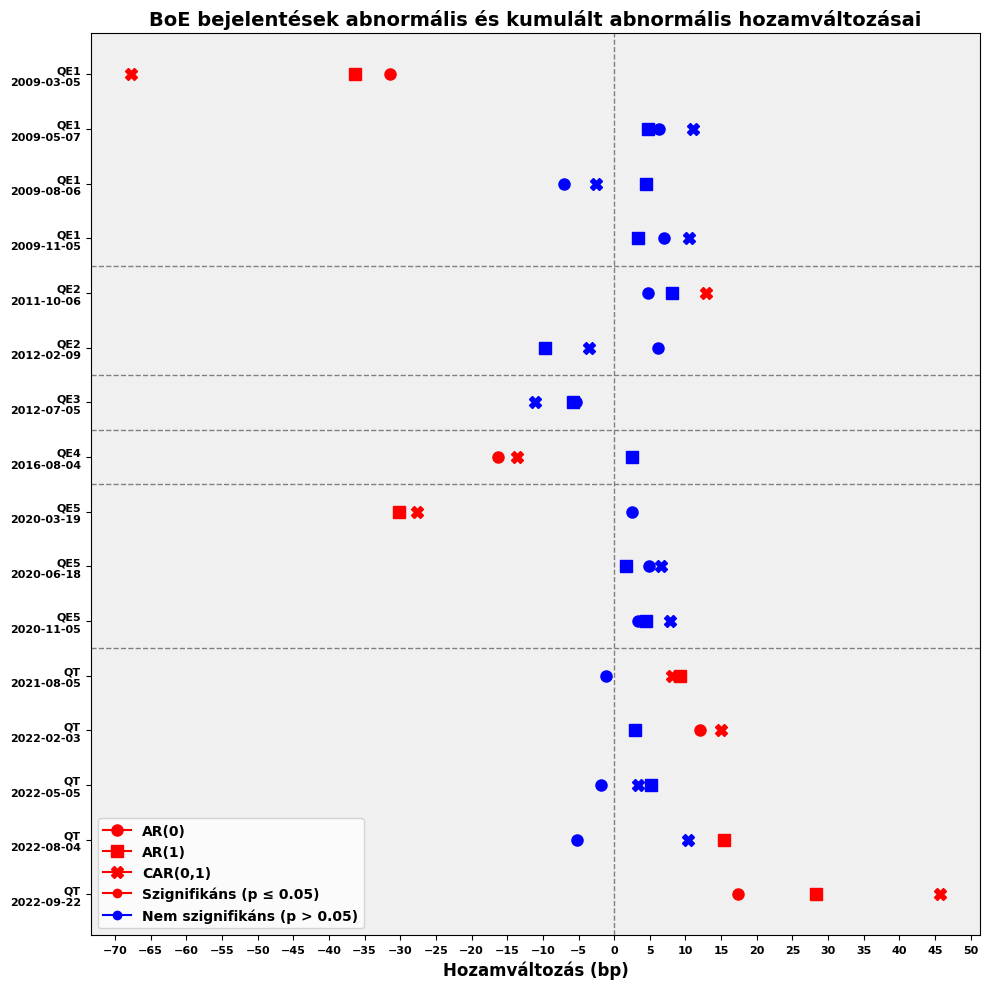

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MultipleLocator

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 10))

# Extract AR(0), AR(1), and CAR(0,1) results along with their p-values for each event
event_dates = []  # Store event dates
categories = []   # Store corresponding categories
ar0 = []          # Store AR(0) results
ar1 = []          # Store AR(1) results
car01 = []        # Store CAR(0,1) results
p_values_ar0 = [] # Store p-values for AR(0)
p_values_ar1 = [] # Store p-values for AR(1)
p_values_car01 = [] # Store p-values for CAR(0,1)

# Iterate over categories and their associated event dates
for category, results_list in results.items():
    for result in results_list:
        # Extract data for the current event
        event_dates.append(result['Event_Date'])
        categories.append(category)
        ar0.append(result['Abnormal_Return'])
        ar1.append(result['Abnormal_Return_Plus_1'])
        car01.append(result['Cumulative_Abnormal_Return'])
        p_values_ar0.append(result['p_value'])
        p_values_ar1.append(result['p_value_plus_1'])
        p_values_car01.append(result['CAR_p_value'])

# Convert lists to arrays
event_dates = np.array(event_dates)
categories = np.array(categories)
ar0 = np.array(ar0)
ar1 = np.array(ar1)
car01 = np.array(car01)
p_values_ar0 = np.array(p_values_ar0)
p_values_ar1 = np.array(p_values_ar1)
p_values_car01 = np.array(p_values_car01)

# Sort event_dates and categories together based on event_dates
sorted_indices = np.argsort(event_dates)
event_dates = event_dates[sorted_indices]
categories = categories[sorted_indices]

# Plot vertical lines for 0 bp change for each group (AR(0), AR(1), CAR(0,1))
ax.axvline(x=0, color='gray', linestyle='--', linewidth=1)

# Define markers for AR(0), AR(1), and CAR(0,1)
markers = ['o', 's', 'X']

# Plot AR(0), AR(1), and CAR(0,1) results for each event with different markers
for i, (ar0_val, ar1_val, car01_val, p_ar0, p_ar1, p_car01) in enumerate(zip(ar0, ar1, car01, p_values_ar0, p_values_ar1, p_values_car01)):
    y = len(event_dates) - i - 1  # Y-position for the current event
    colors = ['blue', 'blue', 'blue']  # Default color for non-significant results
    
    # Check significance based on p-values and assign colors
    if p_ar0 <= 0.05:
        color_ar0 = 'red'  # Red for significant AR(0)
    else:
        color_ar0 = 'blue'  # Blue for non-significant AR(0)
    
    if p_ar1 <= 0.05:
        color_ar1 = 'red'  # Red for significant AR(1)
    else:
        color_ar1 = 'blue'  # Blue for non-significant AR(1)
    
    if p_car01 <= 0.05:
        color_car01 = 'red'  # Red for significant CAR(0,1)
    else:
        color_car01 = 'blue'  # Blue for non-significant CAR(0,1)
    
    # Plot AR(0), AR(1), and CAR(0,1) results for the current event with different markers
    ax.plot(ar0_val, y, marker=markers[0], markersize=8, color=color_ar0, label='AR(0)' if i == 0 else None)
    ax.plot(ar1_val, y, marker=markers[1], markersize=8, color=color_ar1, label='AR(1)' if i == 0 else None)
    ax.plot(car01_val, y, marker=markers[2], markersize=8, color=color_car01, label='CAR(0,1)' if i == 0 else None)

    # Draw horizontal line after a category ends
    if i < len(categories) - 1 and categories[i] != categories[i + 1]:
        ax.axhline(y - 0.5, color='gray', linewidth=1, linestyle='--')

# Label the y-axis with the event dates and categories in a structured way
y_labels = [f'{category}\n{event_date}' for category, event_date in zip(categories, event_dates)]
ax.set_yticks(np.arange(len(y_labels)))
ax.set_yticklabels(y_labels[::-1], fontsize=8, fontweight='bold')

# Set background color
ax.set_facecolor('#f0f0f0')

# Set x-axis label
ax.set_xlabel('Hozamváltozás (bp)', fontsize=12, fontweight='bold')

# Set title
ax.set_title('BoE bejelentések abnormális és kumulált abnormális hozamváltozásai', fontsize=14, fontweight='bold')

# Add legend to indicate the significance of the results
ax.plot([], [], color='red', marker='o', label='Szignifikáns (p ≤ 0.05)')
ax.plot([], [], color='blue', marker='o', label='Nem szignifikáns (p > 0.05)')
ax.legend(loc='lower left', fontsize=10, prop={'weight': 'bold'})

# Set x-axis ticks with a step size of 5
ax.xaxis.set_major_locator(MultipleLocator(5))

# Set x-axis tick labels in bold
plt.setp(ax.get_xticklabels(), fontsize=8, fontweight='bold')

# Show the plot
plt.tight_layout()
plt.show()
# plt.savefig("BoE_1.png")

In [12]:
import numpy as np
import pandas as pd

# Initialize lists to store data
table_data = []

# Iterate over categories and their associated event dates
for category, results_list in results.items():
    for result in results_list:
        # Extract data for the current event
        event_date = result['Event_Date']
        ar0_val = round(result['Abnormal_Return'], 2)
        ar1_val = round(result['Abnormal_Return_Plus_1'], 2)
        car01_val = round(result['Cumulative_Abnormal_Return'], 2)
        p_ar0 = result['p_value']
        p_ar1 = result['p_value_plus_1']
        p_car01 = result['CAR_p_value']
        
        # Define significance based on p-values
        sig_ar0 = 'Szignifikáns (p ≤ 0.05)' if p_ar0 <= 0.05 else 'Nem szignifikáns (p > 0.05)'
        sig_ar1 = 'Szignifikáns (p ≤ 0.05)' if p_ar1 <= 0.05 else 'Nem szignifikáns (p > 0.05)'
        sig_car01 = 'Szignifikáns (p ≤ 0.05)' if p_car01 <= 0.05 else 'Nem szignifikáns (p > 0.05)'
        
        # Append data to the table
        table_data.append([event_date, category, ar0_val, sig_ar0, ar1_val, sig_ar1, car01_val, sig_car01])

# Create a DataFrame for the table
table_columns = ['Dátum', 'Kategória', 'AR(0)', 'P érték (AR(0))', 'AR(1)', 'P érték (AR(1))', 'CAR(0,1)', 'P érték (CAR(0,1))']
table_df = pd.DataFrame(table_data, columns=table_columns)

# Save DataFrame to a CSV file
table_df.to_excel('BoE_table_data_1.xlsx', index=False)

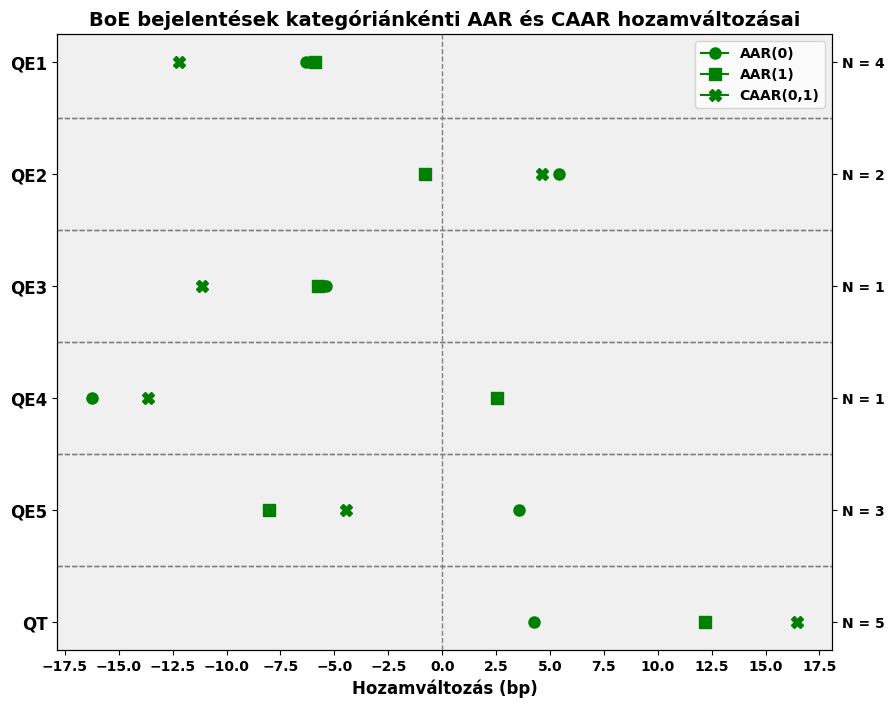

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MultipleLocator

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 8))

# Extract AAR(0) and AAR(1) results for each category
categories = list(aar.keys())
aar0_values = [value['Abnormal_Return'] for value in aar.values()]
aar1_values = [value['Abnormal_Return_Plus_1'] for value in aar.values()]

# Plot vertical lines for 0 bp change for each group (AAR(0) and AAR(1))
ax.axvline(x=0, color='gray', linestyle='--', linewidth=1)

# Define markers for AAR(0) and AAR(1)
markers = ['o', 's']

# Plot AAR(0) and AAR(1) results for each category with green markers
for i, (aar0_val, aar1_val) in enumerate(zip(aar0_values, aar1_values)):
    y = len(categories) - i - 1  # Y-position for the current category
    
    # Plot AAR(0) and AAR(1) results for the current category with green markers
    ax.plot(aar0_val, y, marker=markers[0], markersize=8, color='green', label='AAR(0)' if i == 0 else None)
    ax.plot(aar1_val, y, marker=markers[1], markersize=8, color='green', label='AAR(1)' if i == 0 else None)

    # Draw horizontal line after a category ends
    if i < len(categories) - 1:
        ax.axhline(y - 0.5, color='gray', linewidth=1, linestyle='--')

# Plot CAAR(0,1) results for each category with green markers
for i, (caar_val) in enumerate(caar_individual.values()):
    y = len(categories) - i - 1  # Y-position for the current category
    
    # Plot CAAR(0,1) results for the current category with green markers
    ax.plot(caar_val, y, marker='X', markersize=8, color='green', label='CAAR(0,1)' if i == 0 else None)

    # Draw horizontal line after a category ends
    if i < len(categories) - 1:
        ax.axhline(y - 0.5, color='gray', linewidth=1, linestyle='--')

# Add legend 
ax.legend(loc='upper right', fontsize=10, prop={'weight': 'bold'})

# Label the y-axis with the categories
ax.set_yticks(np.arange(len(categories)))
ax.set_yticklabels(categories[::-1], fontsize=12, fontweight='bold')

# Set background color
ax.set_facecolor('#f0f0f0')

# Set x-axis label
ax.set_xlabel('Hozamváltozás (bp)', fontsize=12, fontweight='bold')

# Set title
ax.set_title('BoE bejelentések kategóriánkénti AAR és CAAR hozamváltozásai', fontsize=14, fontweight='bold')

# Set x-axis ticks with a step size of 5
ax.xaxis.set_major_locator(MultipleLocator(2.5))

# Set x-axis tick labels in bold
plt.setp(ax.get_xticklabels(), fontsize=10, fontweight='bold')

# Create a twin axes for the number of events
ax2 = ax.twinx()

# Set the position of the secondary y-axis ticks to align with the primary y-axis ticks
ax2.set_ylim(ax.get_ylim())

# Set the ticks and labels for the secondary y-axis
ax2.set_yticks(np.arange(len(categories)))
ax2.set_yticklabels([f'N = {len(fed_announcement_dates[cat])}' for cat in categories[::-1]], fontsize=10, fontweight='bold')

# Hide the secondary y-axis
ax2.set_ylabel('')

# Show the plot
#plt.savefig("BoE_2.png", bbox_inches='tight')
plt.show()

In [14]:
# Create a list to store data
data = []

# Iterate over categories
for category in categories:
    # Extract AAR(0), AAR(1), and CAAR(0,1) values for the current category
    aar0_val = round(aar[category]['Abnormal_Return'],2)
    aar1_val = round(aar[category]['Abnormal_Return_Plus_1'],2)
    caar_val = round(caar_individual[category],2)
    # Get the number of events for the current category
    num_events = len(fed_announcement_dates[category])
    
    # Append data to the list
    data.append([category, aar0_val, aar1_val, caar_val, num_events])

# Create a DataFrame
df = pd.DataFrame(data, columns=['Kategória', 'AAR(0)', 'AAR(1)', 'CAAR(0,1)', 'Események száma'])

# Save DataFrame to an Excel file
df.to_excel('BoE_table_data_2.xlsx', index=False)

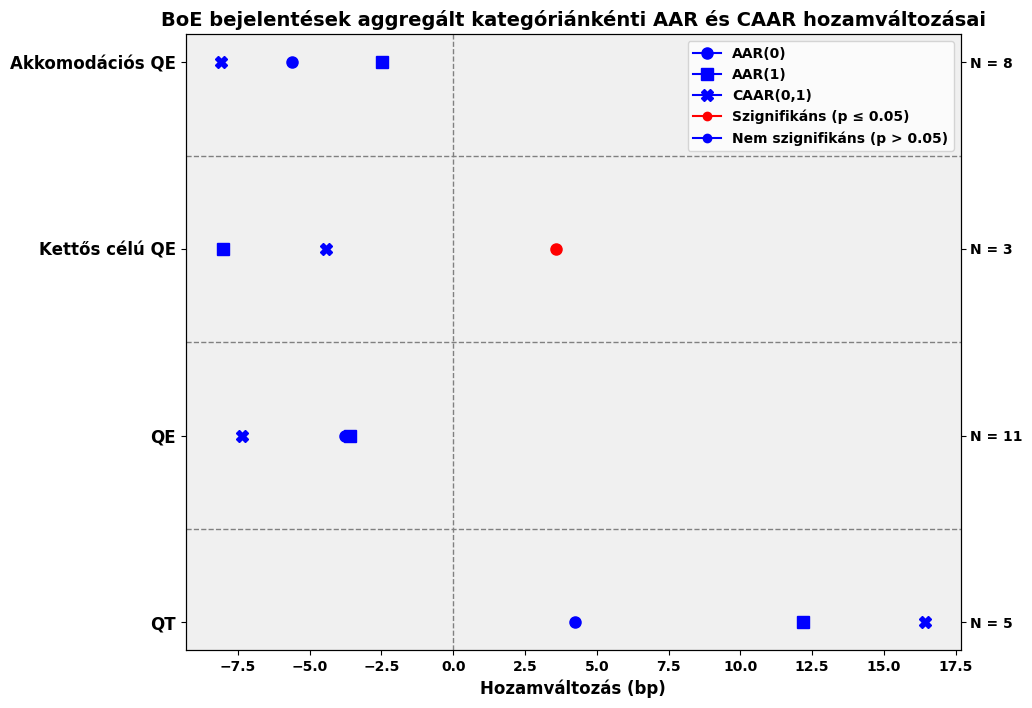

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MultipleLocator

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 8))

# Extract aggregated categories and their AAR(0), AAR(1), and CAAR(0,1) values
categories_aggregated = list(aar_aggregated.keys())
aar0_values_aggregated = [value['Abnormal_Return'] for value in aar_aggregated.values()]
aar1_values_aggregated = [value['Abnormal_Return_Plus_1'] for value in aar_aggregated.values()]
caar_values_aggregated = [caar_aggregated[category] for category in categories_aggregated]

# Convert p_values from NumPy array to dictionary
p_values_dict = {}
for category, stats in p_values.items():
    p_values_dict[category] = {'AAR(0)': stats['AAR(0)'], 'AAR(1)': stats['AAR(1)']}

# Manually input the number of events for each category
events_count = [8, 3, 11, 5]  # Update this list with your own counts

# Plot vertical lines for 0 bp change for each group (AAR(0) and AAR(1))
ax.axvline(x=0, color='gray', linestyle='--', linewidth=1)

# Set colors based on significance level
colors = []
for category in categories_aggregated:
    color_aar0 = 'blue' if p_values_dict[category]['AAR(0)'] > 0.05 else 'red'
    color_aar1 = 'blue' if p_values_dict[category]['AAR(1)'] > 0.05 else 'red'
    color_caar = 'blue' if p_values_caar[category] > 0.05 else 'red'
    colors.append((color_aar0, color_aar1, color_caar))

# Define markers for AAR(0), AAR(1), and CAAR(0,1)
markers = ['o', 's', 'X']

# Plot AAR(0), AAR(1), and CAAR(0,1) results for each aggregated category with significance-based color
for i, (aar0_val, aar1_val, caar_val) in enumerate(zip(aar0_values_aggregated, aar1_values_aggregated, caar_values_aggregated)):
    y = len(categories_aggregated) - i - 1  # Y-position for the current category
    
    # Plot AAR(0), AAR(1), and CAAR(0,1) results for the current category with significance-based color
    ax.plot(aar0_val, y, marker=markers[0], markersize=8, color=colors[i][0], label='AAR(0)' if i == 0 else None)
    ax.plot(aar1_val, y, marker=markers[1], markersize=8, color=colors[i][1], label='AAR(1)' if i == 0 else None)
    ax.plot(caar_val, y, marker=markers[2], markersize=8, color=colors[i][2], label='CAAR(0,1)' if i == 0 else None)

    # Draw horizontal line after a category ends
    if i < len(categories_aggregated) - 1:
        ax.axhline(y - 0.5, color='gray', linewidth=1, linestyle='--')

# Add legend 
ax.plot([], [], color='red', marker='o', label='Szignifikáns (p ≤ 0.05)')
ax.plot([], [], color='blue', marker='o', label='Nem szignifikáns (p > 0.05)')
ax.legend(loc='upper right', fontsize=10, prop={'weight': 'bold'})

# Label the y-axis with the aggregated categories
ax.set_yticks(np.arange(len(categories_aggregated)))
ax.set_yticklabels(categories_aggregated[::-1], fontsize=12, fontweight='bold')

# Set background color
ax.set_facecolor('#f0f0f0')

# Set x-axis label
ax.set_xlabel('Hozamváltozás (bp)', fontsize=12, fontweight='bold')

# Set title
ax.set_title('BoE bejelentések aggregált kategóriánkénti AAR és CAAR hozamváltozásai', fontsize=14, fontweight='bold')

# Set x-axis ticks with a step size of 5
ax.xaxis.set_major_locator(MultipleLocator(2.5))

# Set x-axis tick labels in bold
plt.setp(ax.get_xticklabels(), fontsize=10, fontweight='bold')

# Create a twin axes for the number of events
ax2 = ax.twinx()

# Set the position of the secondary y-axis ticks to align with the primary y-axis ticks
ax2.set_ylim(ax.get_ylim())

# Set the ticks and labels for the secondary y-axis
ax2.set_yticks(np.arange(len(categories_aggregated)))
ax2.set_yticklabels([f'N = {count}' for count in events_count[::-1]], fontsize=10, fontweight='bold')

# Hide the secondary y-axis
ax2.set_ylabel('')

# Show the plot
#plt.savefig("BoE_3.png", bbox_inches='tight')
plt.show()

In [16]:
# Round AAR(0), AAR(1), and CAAR(0,1) values to two decimal places
aar0_values_rounded = [round(val, 2) for val in aar0_values_aggregated]
aar1_values_rounded = [round(val, 2) for val in aar1_values_aggregated]
caar_values_rounded = [round(val, 2) for val in caar_values_aggregated]

# Create a DataFrame
data = {
    'Kategória': categories_aggregated,
    'AAR(0)': aar0_values_rounded,
    'AAR(1)': aar1_values_rounded,
    'CAAR(0,1)': caar_values_rounded,
    'Események száma': events_count
}
df = pd.DataFrame(data)

# Save DataFrame to an Excel file
df.to_excel('BoE_table_data_3.xlsx', index=False)

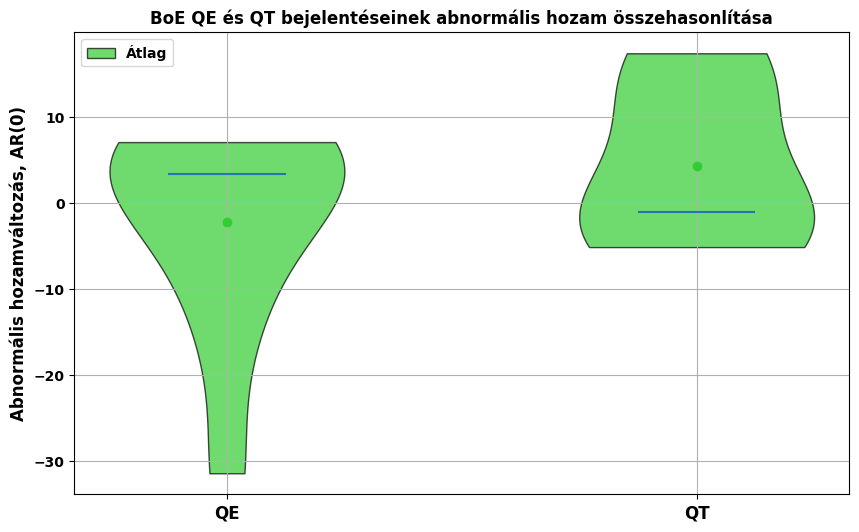

In [27]:
# Violin plot
data = [qe_abnormal_returns, qt_abnormal_returns]

# Create a violin plot with customizations
plt.figure(figsize=(10, 6))
parts = plt.violinplot(data, showmeans=False, showmedians=True, showextrema=False)

# Customizing violins
colors = ['#32CD32', '#32CD32']  # Light green color for both QE and QT
for i, pc in enumerate(parts['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_edgecolor('black')
    pc.set_alpha(0.7)

# Add mean symbols
for i, (color, d) in enumerate(zip(colors, data)):
    plt.scatter([i + 1], [np.mean(d)], color= color, zorder=5)

# Add labels and title
plt.xticks([1, 2], ['QE', 'QT'], weight='bold', fontsize=12)  # Bold and larger x-axis labels
plt.ylabel('Abnormális hozamváltozás, AR(0)', weight='bold', fontsize=12)  # Bold and larger y-axis label
plt.title('BoE QE és QT bejelentéseinek abnormális hozam összehasonlítása', weight='bold')  # Bold title

# Add legend
plt.legend(['Átlag'], loc='upper left', prop={'weight': 'bold'})  # Bold legend

# Bold y-tick labels
plt.yticks(fontweight='bold')

# Show plot
plt.grid(True)
plt.show()

In [15]:
# Create DataFrame
data = {'Aggregated Category': categories_aggregated,
        'AAR(0)': aar0_values_aggregated,
        'p-value': [p_values_dict[cat]['AAR(0)'] for cat in categories_aggregated]}
df = pd.DataFrame(data)
df.to_excel("boe.xlsx")

In [16]:
import pandas as pd
import numpy as np

fed_qe_abnormal_returns = qe_abnormal_returns
fed_qt_abnormal_returns = qt_abnormal_returns

# Determine the length of the longer array
max_length = max(len(fed_qe_abnormal_returns), len(fed_qt_abnormal_returns))

# Pad the shorter array with NaN values to match the length of the longer array
fed_qe_abnormal_returns += [np.nan] * (max_length - len(fed_qe_abnormal_returns))
fed_qt_abnormal_returns += [np.nan] * (max_length - len(fed_qt_abnormal_returns))

# Create DataFrame
data = {'Central Bank': 'BoE',
        'QE': fed_qe_abnormal_returns,
        'QT': fed_qt_abnormal_returns}
df = pd.DataFrame(data)

# Save DataFrame to Excel
df.to_excel("BoE_abnormal_returns.xlsx", index=False)

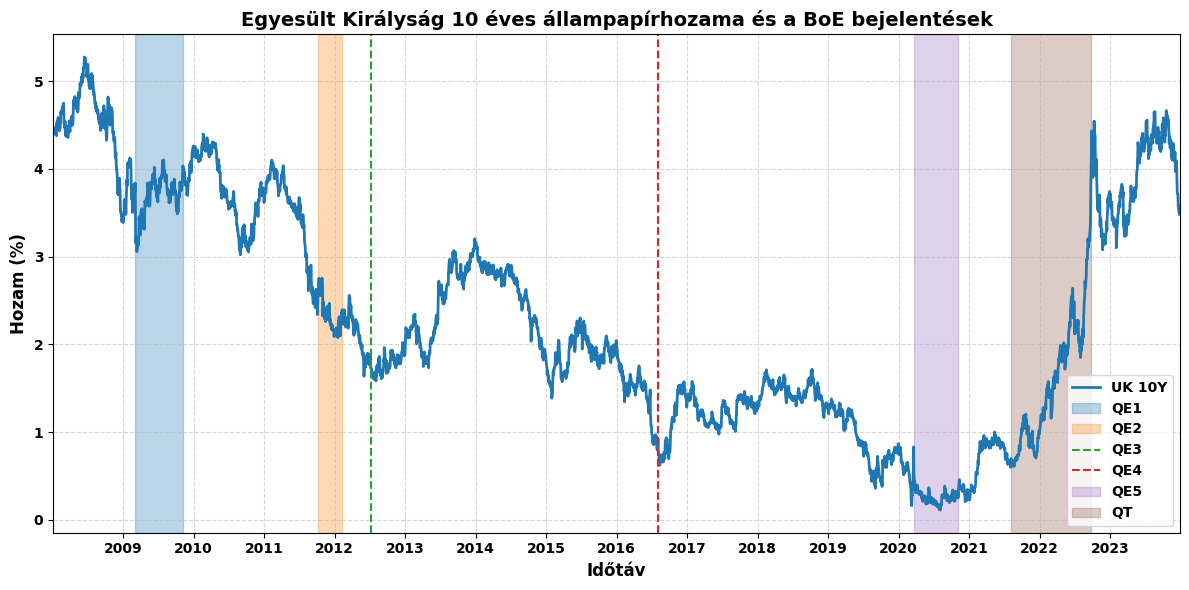

In [3]:
import matplotlib.dates as mdates
import seaborn as sns
import matplotlib.pyplot as plt

# Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Define color palette for different aggregated categories
palette = sns.color_palette("tab10", n_colors=len(fed_announcement_dates))

# Plotting
plt.figure(figsize=(12, 6))

# Plot yields
sns.lineplot(data=df, x='Date', y='UK_yield', label='UK 10Y', linewidth=2)

# Add gridlines
plt.grid(True, linestyle='--', alpha=0.5)

# Plot shaded areas for Fed announcements
for i, (cat, dates) in enumerate(fed_announcement_dates.items()):
    color = palette[i]  # Use color from palette
    if len(dates) > 1:
        start_date = pd.to_datetime(dates[0])
        end_date = pd.to_datetime(dates[-1])
        plt.axvspan(start_date, end_date, color=color, alpha=0.3, label=cat)
    else:
        event_date = pd.to_datetime(dates[0])
        plt.axvline(event_date, color=color, linestyle='--', label=cat)

plt.ylabel('Hozam (%)', fontsize=12, fontweight='bold')
plt.yticks(fontsize=10, fontweight='bold')
plt.title('Egyesült Királyság 10 éves állampapírhozama és a BoE bejelentések', fontsize=14, fontweight='bold')
plt.legend(fontsize=10, loc='lower right', prop={'weight': 'bold'})
plt.xlabel('Időtáv', fontsize=12, fontweight='bold')
plt.xticks(fontsize=10, fontweight='bold')
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format x-ticks to show only the year
plt.xlim(df['Date'].min(), df['Date'].max())  # Set x-axis limits from the first to the last observation
plt.tight_layout()
plt.savefig("UK_10Y.png")
#plt.show()